In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
DATA_DIR = Path("..") / "Datasets" / "Cleaned Data"
import re

In [ ]:
# Load Data
respondents = pd.read_csv(DATA_DIR / "respondents_clean.csv", encoding="latin1")
employment_context = pd.read_csv(DATA_DIR / "employment_context_clean.csv")
remote_work_actual = pd.read_csv(DATA_DIR / "remote_work_actual_clean.csv")
remote_work_preferences = pd.read_csv(DATA_DIR / "remote_work_preferences_clean.csv")
policy_and_support = pd.read_csv(DATA_DIR / "policy_and_support_clean.csv")
outcomes_and_barriers = pd.read_csv(DATA_DIR / "outcomes_and_barriers_clean.csv")

In [ ]:
for df, name in zip([respondents, employment_context, remote_work_actual, remote_work_preferences, policy_and_support, outcomes_and_barriers],
                    ["respondents","employment_context","remote_work_actual","remote_work_preferences","policy_and_support","outcomes_and_barriers"]):
    print(name, df.shape)
respondents.head()


In [11]:
df = remote_work_actual.merge(remote_work_preferences, on=['respondent_id','year']) \
                       .merge(respondents, on='respondent_id') \
                       .merge(employment_context, on='respondent_id') \
                       .merge(policy_and_support, on=['respondent_id','year'], how='left') \
                       .merge(outcomes_and_barriers, on=['respondent_id','year'], how='left')


#### 1. Respondent Demographics

C:\Users\Natasha\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Natasha\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


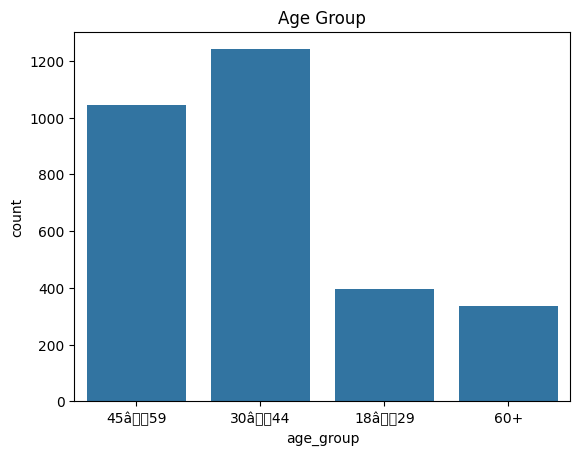

In [21]:
# Age Group Distribution
sns.countplot(data=respondents, x='age_group')
plt.title("Age Group")
plt.show()

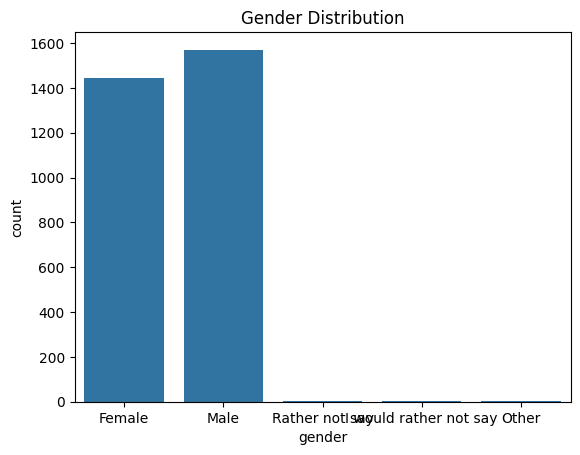

In [ ]:
# Gender Distribution
sns.countplot(data=respondents, x='gender')
plt.title("Gender Distribution")
plt.show()

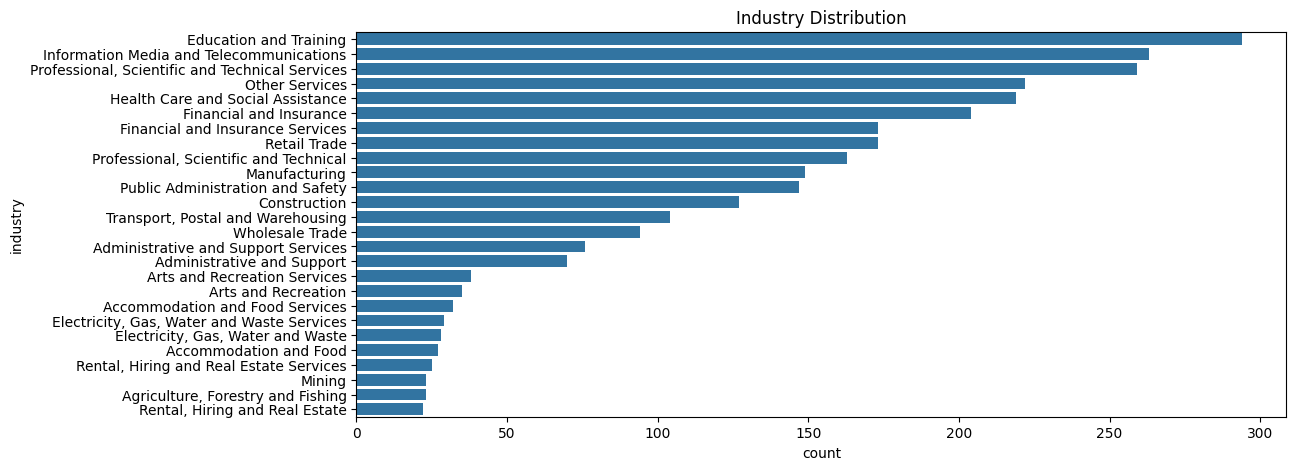

In [14]:
# Industry distribution
plt.figure(figsize=(12,5))
sns.countplot(data=employment_context, y='industry', order=employment_context['industry'].value_counts().index)
plt.title("Industry Distribution")
plt.show()

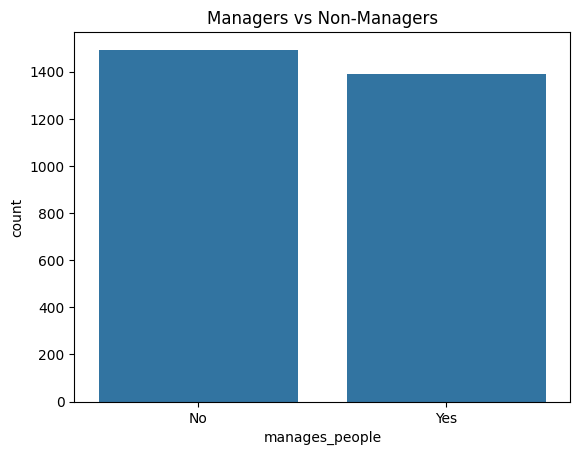

In [15]:
# Managers vs non-managers
sns.countplot(data=employment_context, x='manages_people')
plt.title("Managers vs Non-Managers")
plt.show()

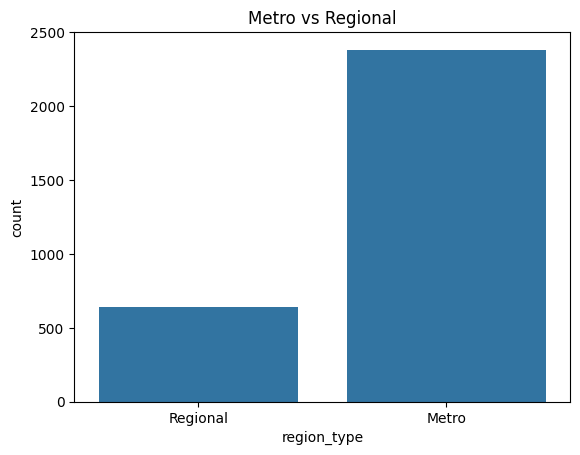

In [19]:
# Metro vs Regional
sns.countplot(data=respondents, x='region_type')
plt.title("Metro vs Regional")
plt.show()

#### 2. Reality Of Remote Work

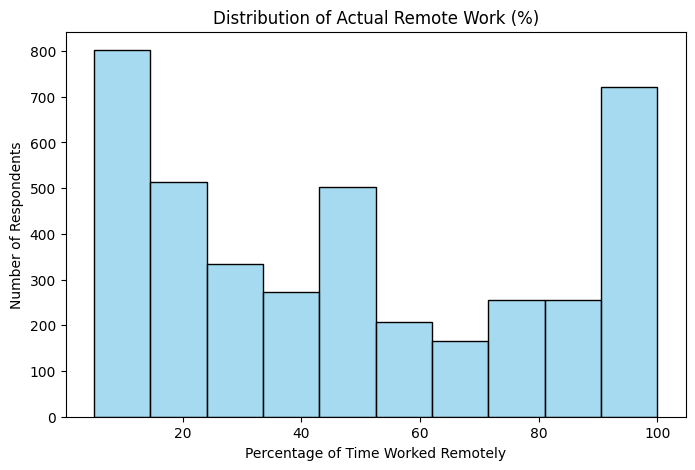

C:\Users\Natasha\AppData\Local\Temp\ipykernel_14852\3588714959.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=remote_work_actual, x='year', y='actual_remote_numeric', palette='pastel')


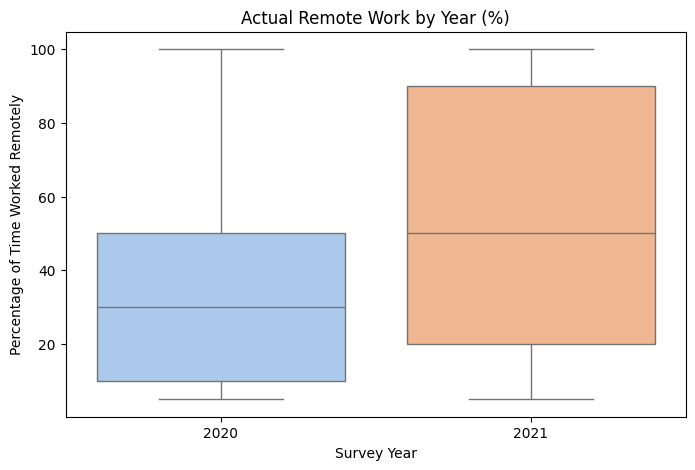

In [ ]:
# Standardize remote work percentage to numeric 0-100
def map_remote(x):
    if isinstance(x, str):
        val = x.strip().lower()
        if val in ['rarely or never', '<10%']:
            return 5
        elif 'half' in val:
            return 50
        elif 'all my time' in val or '100%' in val:
            return 100
        else:
            try:
                return float(val.replace('%',''))
            except:
                return None
    elif isinstance(x, (int, float)):
        return x
    return None

remote_work_actual['actual_remote_numeric'] = remote_work_actual['remote_pct_actual'].apply(map_remote)

# Distribution plot
plt.figure(figsize=(8,5))
sns.histplot(remote_work_actual['actual_remote_numeric'], bins=10, color='skyblue')
plt.title("Distribution of Actual Remote Work (%)")
plt.xlabel("Percentage of Time Worked Remotely")
plt.ylabel("Number of Respondents")
plt.show()

# Yearly comparison boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=remote_work_actual, x='year', y='actual_remote_numeric', palette='pastel')
plt.title("Actual Remote Work by Year (%)")
plt.xlabel("Survey Year")
plt.ylabel("Percentage of Time Worked Remotely")
plt.show()


#### 3. Preferences VS Prevailing Conditions

In [ ]:
# Standardize preferred remote work % to numeric 0-100
def map_preferred_remote(x):
    if isinstance(x, str):
        val = x.strip().lower()
        # Verbal responses
        if val in ['rarely or never', '<10%']:
            return 5
        elif 'half' in val or '50%' in val:
            return 50
        elif 'all my time' in val or '100%' in val:
            return 100
        else:
            # Remove % and convert if possible
            try:
                return float(val.replace('%',''))
            except:
                return None
    elif isinstance(x, (int, float)):
        return x
    return None

remote_work_preferences['preferred_remote_numeric'] = remote_work_preferences['remote_pct_preferred'].apply(map_preferred_remote)

# Preferred remote work distribution
plt.figure(figsize=(8,5))
sns.histplot(remote_work_preferences['preferred_remote_numeric'], bins=10, kde=True, color='lightgreen')
plt.title("Distribution of Preferred Remote Work (%)")
plt.xlabel("Percentage of Time Preferred Remotely")
plt.ylabel("Number of Respondents")
plt.show()

# Compare actual vs preferred
merged = remote_work_actual.merge(remote_work_preferences, on=['respondent_id','year'])
merged_long = pd.melt(
    merged, 
    id_vars=['respondent_id','year'], 
    value_vars=['actual_remote_numeric','preferred_remote_numeric'],
    var_name='type', 
    value_name='remote_pct'
)

plt.figure(figsize=(8,5))
sns.boxplot(data=merged_long, x='type', y='remote_pct', palette='pastel')
plt.title("Actual vs Preferred Remote Work (%)")
plt.xlabel("Type of Remote Work")
plt.ylabel("Percentage of Time Worked/Preferred Remotely")
plt.show()


#### 4. Mismatch

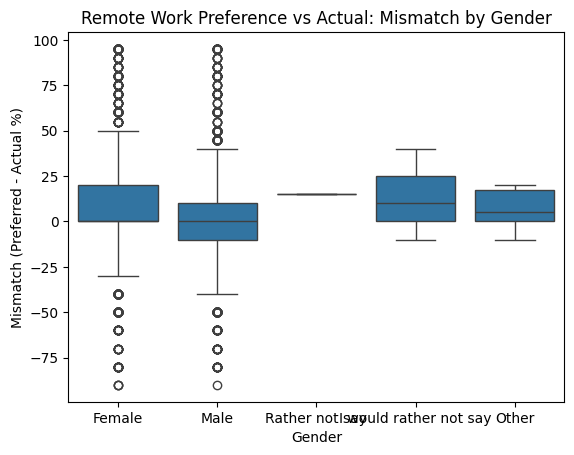

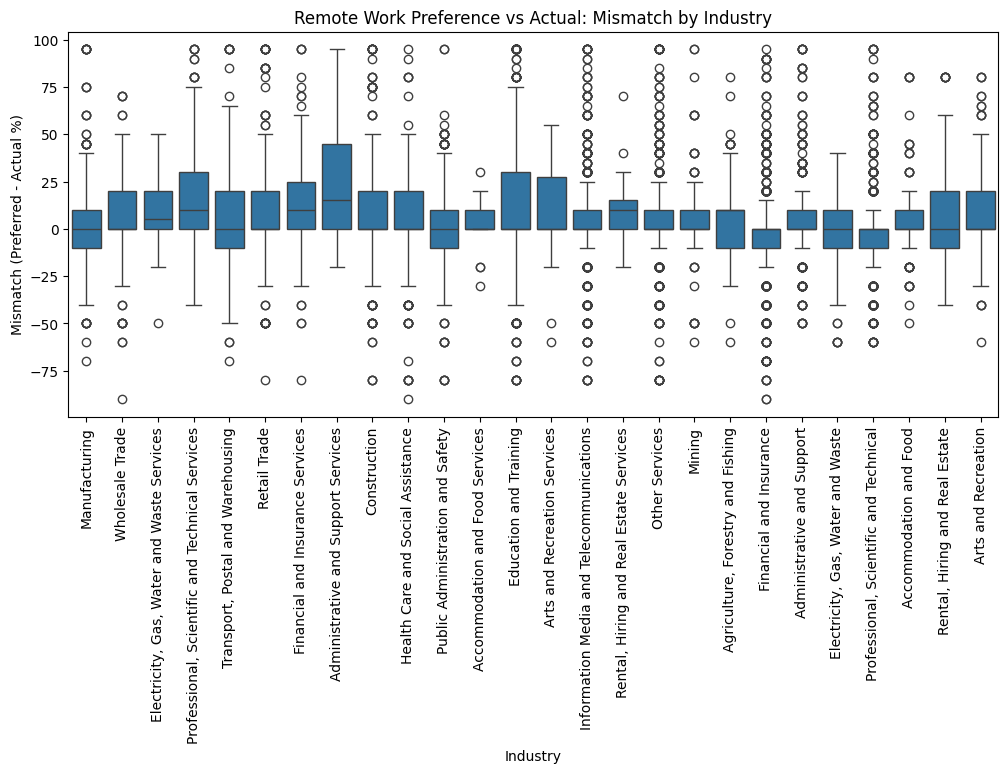

In [ ]:
# Create mismatch metric
merged['mismatch'] = merged['preferred_remote_numeric'] - merged['actual_remote_numeric']

# Mismatch by gender
sns.boxplot(
    data=merged.merge(respondents[['respondent_id','gender']], on='respondent_id'),
    x='gender',
    y='mismatch'
)
plt.title("Remote Work Preference vs Actual: Mismatch by Gender")
plt.xlabel("Gender")
plt.ylabel("Mismatch (Preferred - Actual %)")
plt.show()

# Mismatch by industry
merged_industry = merged.merge(employment_context[['respondent_id','industry']], on='respondent_id')
plt.figure(figsize=(12,5))
sns.boxplot(data=merged_industry, x='industry', y='mismatch')
plt.xticks(rotation=90)
plt.title("Remote Work Preference vs Actual: Mismatch by Industry")
plt.xlabel("Industry")
plt.ylabel("Mismatch (Preferred - Actual %)")
plt.show()

C:\Users\Natasha\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 146 (\x92) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


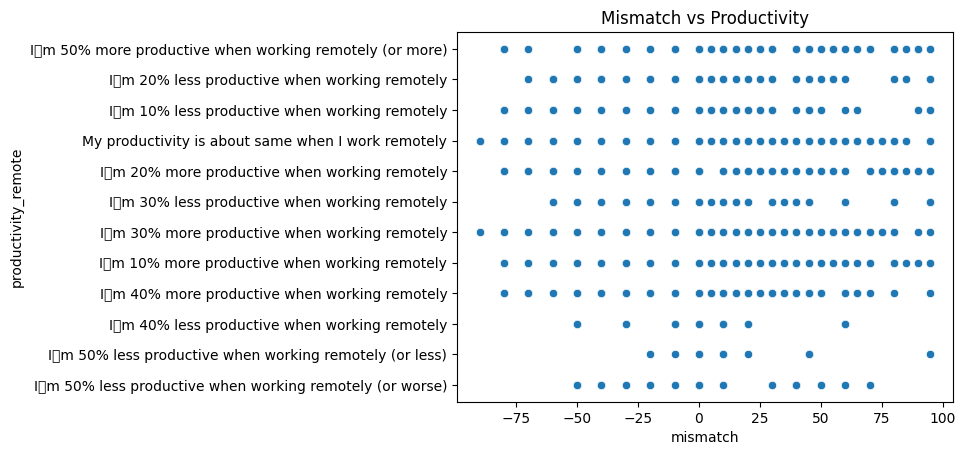

In [51]:
# Join outcomes
merged_outcomes = merged.merge(outcomes_and_barriers, on=['respondent_id','year'])

# Productivity vs mismatch
sns.scatterplot(data=merged_outcomes, x='mismatch', y='productivity_remote')
plt.title("Mismatch vs Productivity")
plt.show()

# Barriers — distribution
barriers_long = pd.melt(outcomes_and_barriers, id_vars=['respondent_id','year'], 
                        value_vars=[col for col in outcomes_and_barriers.columns if 'barrier' in col],
                        var_name='barrier', value_name='severity')


### HYPOTHESIS TESTING

In [64]:
def convert_to_numeric(x):
    """
    Converts strings like '100%', '50 - I spend this amount of time', '<10%' etc. to numeric 0-100 scale
    """
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    
    # Handle simple percentages
    if x.endswith('%'):
        return float(x.replace('%',''))
    
    # Handle ranges like '50 - I spend this amount of time'
    if ' - ' in x:
        try:
            return float(x.split(' - ')[0])
        except:
            return np.nan
    
    # Handle less than e.g., '<10%'
    if x.startswith('<'):
        try:
            return float(x[1:])
        except:
            return np.nan
    
    # Handle greater than e.g., '>90%'
    if x.startswith('>'):
        try:
            return float(x[1:])
        except:
            return np.nan
    
    # Default: try numeric conversion
    try:
        return float(x)
    except:
        return np.nan

# Apply to actual and preferred remote work columns
for col in ['remote_pct_actual','remote_pct_preferred']:
    if col in remote_work_actual.columns:
        remote_work_actual[col] = remote_work_actual[col].apply(convert_to_numeric)
    if col in remote_work_preferences.columns:
        remote_work_preferences[col] = remote_work_preferences[col].apply(convert_to_numeric)


In [65]:
merged = remote_work_actual.merge(remote_work_preferences, on=['respondent_id','year'], how='outer')
merged['mismatch'] = merged['remote_pct_preferred'] - merged['remote_pct_actual']


#### Hypothesis 1 — Mismatch exists

Mismatch refers to the gap between how much time respondents actually spent working remotely vs how much they wanted to spend working remotely

Positive mismatch → respondent wanted more remote work than they actually did.

Negative mismatch → respondent wanted less remote work than they actually did.

Zero → respondent’s preferred remote work matched reality.

In [66]:
t_stat, p_val = stats.ttest_1samp(merged['mismatch'].dropna(), 0)
print("H1 — T-statistic:", t_stat, "P-value:", p_val)


H1 — T-statistic: 6.359779907027924 P-value: 2.2668635132668125e-10


#### Hypothesis 2 — Mismatch differs by groups

In [67]:
# Clean categorical columns
employment_context['manages_people'] = employment_context['manages_people'].str.strip()
employment_context['industry'] = employment_context['industry'].str.strip()

# Merge group info
merged = merged.merge(employment_context[['respondent_id','manages_people','industry']], on='respondent_id', how='left')

# Managers vs Non-managers
group_mgr = [merged[merged['manages_people']=='Yes']['mismatch'].dropna(),
             merged[merged['manages_people']=='No']['mismatch'].dropna()]
t_stat, p_val = stats.ttest_ind(*group_mgr)
print("H2 — Managers vs Non-managers t-test:", t_stat, p_val)

# Industry differences
industries = [grp['mismatch'].dropna() for _, grp in merged.groupby('industry')]
f_stat, p_val = stats.f_oneway(*industries)
print("H2 — Industry ANOVA:", f_stat, p_val)


H2 — Managers vs Non-managers t-test: -0.8141084405555011 0.4156359532006776
H2 — Industry ANOVA: 5.481229304103669 4.711026297339034e-17


#### Hypothesis 3 — Mismatch affects outcomes

In [ ]:
def productivity_to_numeric(x):
    if pd.isna(x):
        return np.nan
    x = str(x).lower()
    if 'more productive' in x:
        num = re.findall(r'\d+', x)
        return float(num[0]) if num else 50
    elif 'less productive' in x:
        num = re.findall(r'\d+', x)
        return -float(num[0]) if num else -50
    elif 'same' in x:
        return 0
    else:
        try:
            return float(re.findall(r'\d+', x)[0])
        except:
            return np.nan

# Apply conversion
outcomes_and_barriers['productivity_numeric'] = outcomes_and_barriers['productivity_remote'].apply(productivity_to_numeric)

# Merge with mismatch table
merged_outcomes = merged.merge(
    outcomes_and_barriers[['respondent_id', 'year', 'productivity_numeric']],
    on=['respondent_id', 'year'],
    how='left'
)

# Spearman correlation
corr, p_val = stats.spearmanr(merged_outcomes['mismatch'], merged_outcomes['productivity_numeric'], nan_policy='omit')
print("H3 — Spearman correlation mismatch vs productivity:", corr, p_val)

# Linear regression
X = sm.add_constant(merged_outcomes['mismatch'])
y = merged_outcomes['productivity_numeric']
model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())

H3 — Spearman correlation mismatch vs productivity: 0.09261656204943872 1.6479580204583925e-08
                             OLS Regression Results                             
Dep. Variable:     productivity_numeric   R-squared:                       0.012
Model:                              OLS   Adj. R-squared:                  0.012
Method:                   Least Squares   F-statistic:                     44.59
Date:                  Fri, 26 Dec 2025   Prob (F-statistic):           2.80e-11
Time:                          16:01:15   Log-Likelihood:                -16778.
No. Observations:                  3702   AIC:                         3.356e+04
Df Residuals:                      3700   BIC:                         3.357e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

#### Hypothesis 4 — Policy moderates mismatch

In [78]:
# Ensure correct ID column
policy_and_support_numeric = policy_and_support.copy()
policy_and_support_numeric.rename(columns={'response_id':'respondent_id'}, inplace=True)

# Strip whitespace and standardize text for mapping
for col in ['org_encouragement', 'org_preparedness', 'policy_suits_me', 'choice_autonomy']:
    policy_and_support_numeric[col] = policy_and_support_numeric[col].str.strip().str.title()
    # Map Likert to numeric
    policy_and_support_numeric[col] = policy_and_support_numeric[col].map({
        "Strongly Disagree": 1,
        "Disagree": 2,
        "Neutral": 3,
        "Agree": 4,
        "Strongly Agree": 5
    })

# Compute composite score
policy_and_support_numeric['policy_support_score'] = policy_and_support_numeric[
    ['org_encouragement', 'org_preparedness', 'policy_suits_me', 'choice_autonomy']
].mean(axis=1)

# Check column exists
print(policy_and_support_numeric.columns)

# Merge with merged_outcomes
merged_outcomes = merged_outcomes.merge(
    policy_and_support_numeric[['respondent_id', 'year', 'policy_support_score']],
    on=['respondent_id', 'year'],
    how='left'
)

# Confirm merge
print(merged_outcomes[['respondent_id', 'year', 'policy_support_score']].head())

# Spearman correlation
corr, p_val = stats.spearmanr(
    merged_outcomes['policy_support_score'], 
    merged_outcomes['mismatch'], 
    nan_policy='omit'
)
print("H4 — Policy support vs mismatch correlation:", corr, p_val)

# Regression
X = merged_outcomes[['mismatch', 'policy_support_score']]
X = sm.add_constant(X)
y = merged_outcomes['productivity_numeric']
model2 = sm.OLS(y, X, missing='drop').fit()
print(model2.summary())


Index(['respondent_id', 'year', 'org_encouragement', 'org_preparedness',
       'policy_suits_me', 'choice_autonomy', 'policy_support_score'],
      dtype='object')
  respondent_id  year  policy_support_score
0        2020_1  2020                   NaN
1       2020_10  2020                   NaN
2      2020_100  2020                   NaN
3     2020_1000  2020                   NaN
4     2020_1001  2020                   3.0
H4 — Policy support vs mismatch correlation: -0.18947323655840537 4.16025343708214e-15
                             OLS Regression Results                             
Dep. Variable:     productivity_numeric   R-squared:                       0.023
Model:                              OLS   Adj. R-squared:                  0.022
Method:                   Least Squares   F-statistic:                     20.15
Date:                  Fri, 26 Dec 2025   Prob (F-statistic):           2.25e-09
Time:                          16:17:28   Log-Likelihood:                -7659.